This notebook produces the figure showing the accuracy of each method under the effects of diffusion. 

In [1]:
import itertools

import numpy as np
import pandas as pd
from persistomics import spatial
import scipy.stats

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

plt.rcParams['figure.figsize'] = (10,10)
plt.rc('axes', linewidth=2)

In [75]:
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def hex_to_rgb(h):
    return tuple(int(h[i+1:i+3], 16) for i in (0, 2, 4))

In [68]:
# Orderings of cell types in ground truth and TopACT-predicted data
# One is alphabetical, the other is by total number of cells in snRNA-seq
ACTUAL_CELLTYPES = ['PT', 'TAL', 'DCT', 'ENDO', 'VSM', 'CCD', 'IMMUNE', 'PODS', 'UROTHELIUM']
ALPHABETICAL_CELLTYPES = ['CCD', 'DCT', 'ENDO', 'IMMUNE', 'PODS', 'PT', 'TAL', 'UROTHELIUM', 'VSM']

In [69]:
topact_values = []
bin20_values = []
rctd_values = []
# The slightly odd order here is because we apply diffusion (i//10 + 1) for experiments i = 0,..,69 and 0 diffusion to experiments 70-79
# The end result is that the i'th experiment in our list has diffusion i//10
# We store the accuracies of each iteration in these lists
for i in list(range(70,80)) + list(range(70)):
        
    # Ground truth cell types
    actual = np.loadtxt(f'../topact-data/syntheticdata/groundtruth/celltypegrid_{i}.txt')
    
    

    # TOPACT PREDICTIONS
    
    # Convert indices to match order of ground truth cell types
    def convert_topact(image):
        
        def convert_coord(p):
            x = image[p]
            if np.isnan(x):
                return -1 # Represents missing prediction
            return ACTUAL_CELLTYPES.index(ALPHABETICAL_CELLTYPES[int(x)])
        
        return np.array(list(map(convert_coord, itertools.product(range(500), range(500))))).reshape((500,500))
    
    # TopACT confidence matrix
    predicted = np.loadtxt(f'../topact-data/syntheticdata/topactpreds_diffuse/topactpreds_diffuse_{i}.txt')
    # Convert to ground truth cell type indices
    predicted = convert_topact(predicted)
    
    # This is the accuracy of the underlying prediction
    topact_values.append(len(np.where(predicted == actual)[0]) / (500*500))
    
    
    
    # RCTD PREDICTIONS
    
    rctd = pd.read_csv(f'../topact-data/syntheticdata/rctdoutput_diffuse/rctd_diffuse_{i}.csv')

    rctd.rename(columns={ rctd.columns[0]: "spot" }, inplace = True)
    
    # Extract cell cords from RCTD output array
    rctd['x'] = list(map(lambda x: int(x[4:].split('.')[0]), rctd['spot']))
    rctd['y'] = list(map(lambda x: int(x[4:].split('.')[1]), rctd['spot']))
    rctdarr = np.zeros((500,500)).astype('int') - 1 # -1 represents missing prediction
    for row in rctd.itertuples():
        # For each predicted cell type, assign prediction to whole bin
        # WARNING: in SciPy >= 1.11.0 this will need to be changed as the mode function is being updated
        rctdarr[row.x*20:row.x*20+20, row.y*20:row.y*20+20] = ACTUAL_CELLTYPES.index(row.first_type)
        
    rctd_values.append(len(np.where(rctdarr == actual)[0]) / (500*500))
    
    
    # MODAL BIN 20 PREDICTIONS
    
    bin20arr = np.zeros((500,500))
    for i in range(0, 500, 20):
        for j in range(0, 500, 20):

            # Each bin is assigned its modal cell type
            thebin = actual[i:i+20,j:j+20].astype('int')

            celltype = scipy.stats.mode(thebin, axis=None)[0][0]
            bin20arr[i:i+20,j:j+20] = celltype

    bin20_values.append(len(np.where(bin20arr == actual)[0]) / (500*500))
    

In [70]:
iterations = list(range(70,80)) + list(range(70))

In [71]:
df = pd.DataFrame([{'Method': 'TopACT', 'Display': 'TopACT\n(Bin 1)', 'Accuracy': x, 'Diffusion': i//10, 'Iteration': iterations[i]} for i, x in enumerate(topact_values)] + 
                  [{'Method': 'Modal', 'Display': 'Modal\n(Bin 20)', 'Accuracy': x, 'Diffusion': i//10 , 'Iteration': iterations[i]} for i, x in enumerate(bin20_values)] +
                 [{'Method': 'RCTD', 'Display': 'RCTD\n(Bin 20)', 'Accuracy': x, 'Diffusion': i//10, 'Iteration': iterations[i] } for i, x in enumerate(rctd_values)])

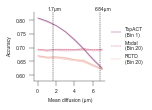

In [76]:
sns.set(style="ticks", context='paper', font="Arial")
plt.rc('axes', linewidth=1*cm)
cm = 1/2.54  # centimeters in inches
plt.rcParams['figure.figsize'] = (3.22*cm, 3.2*cm)


b = sns.lineplot(data=df, errorbar='se', markers=False, markersize=2, markeredgewidth=0, err_style='band', x='Diffusion', y='Accuracy', hue='Display', style='Display', palette='flare_r', linewidth=1*cm)

b.set_xlabel("Mean diffusion (μm)",fontsize=5)
b.set_ylabel("Accuracy",fontsize=5)
b.tick_params(labelsize=5)

plt.plot([6.84, 6.84], [0, 1], linestyle='--', color='black', linewidth=1*cm)
plt.plot([1.7, 1.7], [0, 1], linestyle='--', color='black', linewidth=1*cm)

plt.ylim([0.58, 0.83])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1*cm)
ax.spines['bottom'].set_linewidth(1*cm)
ax.xaxis.set_tick_params(width=1*cm)
ax.yaxis.set_tick_params(width=1*cm)
# handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(loc="upper right", fontsize=5, frameon=False, bbox_to_anchor=(1.6, 0.85), title_fontsize=5)

for line in legend.get_lines():
    line.set_linewidth(1*cm)
# legend = ax.legend(loc='upper right', handles=handles[0:], labels=labels[0:], bbox_to_anchor=(1.15, 1.25), handletextpad=0.1, ncol=2, frameon=False, fontsize=16)    


# legend = ax.legend(handles=handles[0:], labels=labels[0:], frameon=False, fontsize=16, loc="upper right")
plt.text(6.2, 0.835, '6.84μm', fontsize=5)
plt.text(1.1, 0.835, '1.7μm', fontsize=5)

plt.savefig('diffusion.pdf', transparent=True, bbox_inches='tight')